In [176]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
class MACDRSIStrategy(CtaTemplate):
    className = 'MARSIStrategy'
    author = 'Carey'
    amWindow = 20
    # 策略参数
    macdfastPeriod = 12; macdslowPeriod = 26; macdsignalPeriod = 9
    rsishortPeriod = 6; rsilongPeriod = 12
    stopRatio = 0.04
    #trailingPct = 0.04
    lot = 1
    # 策略变量
    transactionPrice = {} # 记录成交价格
    intraTradeHighDict = {}; intraTradeLowDict = {}
    macd = {}
    # 参数列表，保存了参数的名称
    paramList = [
                 'amWindow',
                 "macdfastPeriod" , "macdslowPeriod", "macdsignalPeriod"
                 "rsishortPeriod" , "rsilongPeriod",
                 'stopRatio']                        ##参数列表不用写手数
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
               'intraTradeHighDict', 'intraTradeLowDict'
               "macd"]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把本策略对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.macd = {s:0 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
    """
    def onBar(self, bar):
        #收到Bar推送
        symbol = bar.vtSymbol
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:  ##如果没有持仓(包含多头和空头)
            self.intraTradeHighDict[symbol] = 0  ##仓位管理固定比例吊灯止损止盈
            self.intraTradeLowDict[symbol] = 999999
        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])
        # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()
        """
    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return
        diff = ta.EMA(am60.close,self.macdfastPeriod) - ta.EMA(am60.close,self.macdslowPeriod)
        dea = ta.EMA(diff,self.macdsignalPeriod)
        macd = (diff - dea) * 2
        
        if (diff[-1]>dea[-1]) and (diff[-2]<=dea[-2]) and (macd[-1]>0):
            self.macd[symbol] = 1
        elif (diff[-1]<dea[-1]) and (diff[-2]>=dea[-2]) and (macd[-1]<=0):
            self.macd[symbol] = -1
        self.putEvent()
        
    def on30MinBar(self, bar):
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "30m")
        if not am30.inited:
            return
        rsifast = ta.RSI(am30.close, self.rsishortPeriod)
        rsislow = ta.RSI(am30.close, self.rsilongPeriod)
        
        rsilong = (rsifast[-1]>rsislow[-1]) and (rsifast[-2]<=rsislow[-2]) and (rsifast[-1]>50)
        rsishort = (rsifast[-1]<rsislow[-1]) and (rsifast[-2]>=rsislow[-2]) and (rsifast[-1]<=50)
        
         # 趋势为多头
        if (rsilong) and (self.macd[symbol]==1):  #如果满足信号 
            if  (self.posDict[symbol+'_SHORT']==0) and (self.posDict[symbol+'_LONG']==0):  #没有持仓
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 趋势为空头
        if (rsishort) and (self.macd[symbol]==-1):
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
                
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [177]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181122 12:00') # 设置回测用的数据终止日期
# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [178]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDRSIStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDRSIStrategy.on60MinBar at 0x1a304f3598>, <__main__.MACDRSIStrategy object at 0x1a3a1d1eb8>)
[DEBUG] 注册品种EOSUSDT:binance上的on_30Min_bar函数functools.partial(<function MACDRSIStrategy.on30MinBar at 0x1a304f3488>, <__main__.MACDRSIStrategy object at 0x1a3a1d1eb8>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MACDRSIStrategy.onBar at 0x1a304f3510>, <__main__.MACDRSIStrategy object at 0x1a3a1d1eb8>)
2018-12-05 09:09:05.155883	开始回测
2018-12-05 09:09:05.155926	策略初始化
2018-12-05 09:09:05.157061	载入历史数据。数据范围:[20180622 16:00,20180701 00:00)
2018-12-05 09:09:05.651704	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-05 09:09:05.654081	载入完成，数据量：11295
2018-12-05 09:09:05.654229	策略初始化完成
2018-12-05 09:09:05.654255	策略启动完成
2018-12-05 09:09:05.654290	开始回放回测数据,回测范围:[20180701 00:00,20181122 12:00)
2018-12-05 09:09:05.667267	载入历史数据。数据范围:[20180701 00:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.13.dev1811227-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180626090000 , 20180630230000]
[INFO] 品种EOSUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180701000000
[INFO] 品种EOSUSDT:binance的历史30mK线更新，范围为:[20180628220000 , 20180630233000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180701000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180701000000
[INFO] 品种EOSUSDT:binance开始生成30mK线数据,时间起点为:20180701000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 8.0545, 'high': 8.0734, 'low': 7.95, 'close': 7.9628, 'date': '20180701', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 0, 0), 'volume': 190407.00000000003, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史30mK线更新，范围为:[20180628223000 , 20180701000000]
[INFO] 品种EOSUSDT:binance的30mK线准备就绪,当前K线时间为20180701000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 8.0545, 'high': 

In [179]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-20 07:30:00,多,,,0.0,,开仓,319,,4.1644,0.0,None,,,319,2018-11-20 07:30:00,1,319,EOSUSDT:binance,319
2018-11-20 14:49:00,空,,,0.0,,平仓,320,,3.9851,0.0,None,,,320,2018-11-20 14:49:00,1,320,EOSUSDT:binance,320
2018-11-21 05:30:00,多,,,0.0,,开仓,321,,3.8373,0.0,None,,,321,2018-11-21 05:30:00,1,321,EOSUSDT:binance,321
2018-11-21 09:15:00,空,,,0.0,,平仓,322,,3.6572,0.0,None,,,322,2018-11-21 09:15:00,1,322,EOSUSDT:binance,322
2018-11-21 10:30:00,多,,,0.0,,开仓,323,,3.7555,0.0,None,,,323,2018-11-21 10:30:00,1,323,EOSUSDT:binance,323


2018-12-05 09:09:29.108147	计算按日统计结果
2018-12-05 09:09:29.137171	------------------------------
2018-12-05 09:09:29.137326	首个交易日：	2018-07-01 00:00:00
2018-12-05 09:09:29.137356	最后交易日：	2018-11-22 00:00:00
2018-12-05 09:09:29.137380	总交易日：	145
2018-12-05 09:09:29.137404	盈利交易日	73
2018-12-05 09:09:29.137428	亏损交易日：	71
2018-12-05 09:09:29.137452	起始资金：	1000000
2018-12-05 09:09:29.137506	结束资金：	1,000,003.43
2018-12-05 09:09:29.137545	总收益率：	0.0%
2018-12-05 09:09:29.137581	年化收益：	0.0%
2018-12-05 09:09:29.137618	总盈亏：	3.43
2018-12-05 09:09:29.137654	最大回撤: 	-1.59
2018-12-05 09:09:29.137691	百分比最大回撤: -0.0%
2018-12-05 09:09:29.137727	总手续费：	0.97
2018-12-05 09:09:29.137764	总滑点：	0.65
2018-12-05 09:09:29.137799	总成交金额：	1,931.97
2018-12-05 09:09:29.137831	总成交笔数：	323
2018-12-05 09:09:29.137866	日均盈亏：	0.02
2018-12-05 09:09:29.137901	日均手续费：	0.01
2018-12-05 09:09:29.137936	日均滑点：	0.0
2018-12-05 09:09:29.137971	日均成交金额：	13.32
2018-12-05 09:09:29.138007	日均成交笔数：	2.23
2018-12-05 09:09:29.138036	日均收益率：	0.0%
2018-12-05 09:09

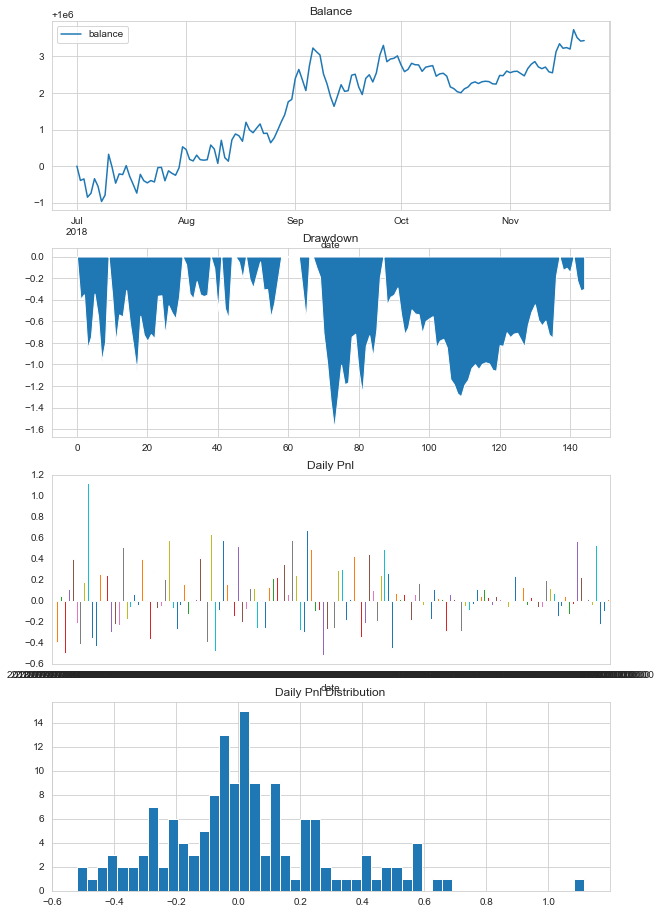

In [180]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-05 09:01:36.409256	计算回测结果
2018-12-05 09:01:36.425027	------------------------------
2018-12-05 09:01:36.425161	第一笔交易：	2018-07-02 21:29:00
2018-12-05 09:01:36.425187	最后一笔交易：	2018-11-22 11:58:00
2018-12-05 09:01:36.425213	总交易次数：	152
2018-12-05 09:01:36.425242	总盈亏：	2.11
2018-12-05 09:01:36.425268	最大回撤: 	-2.83
2018-12-05 09:01:36.425290	平均每笔盈利：	0.01
2018-12-05 09:01:36.425312	平均每笔滑点：	0.0
2018-12-05 09:01:36.425333	平均每笔佣金：	0.01
2018-12-05 09:01:36.425354	胜率		34.87%
2018-12-05 09:01:36.425375	盈利交易平均值	0.26
2018-12-05 09:01:36.425396	亏损交易平均值	-0.12
2018-12-05 09:01:36.425417	盈亏比：	2.21


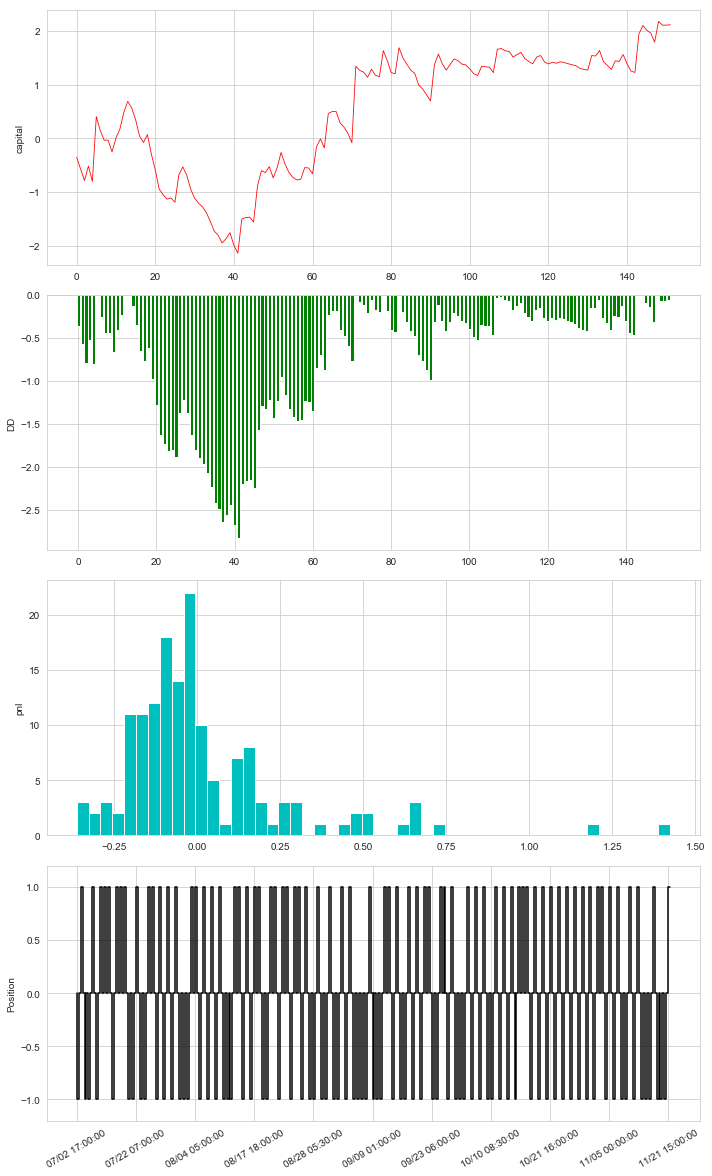

In [174]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [158]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-05 08:57:43.971799	计算按日统计结果


In [159]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-07-01 00:00:00
endDate             2018-11-22 00:00:00
totalDays                           145
profitDays                           66
lossDays                             78
endBalance                        1e+06
maxDrawdown                    -2.08412
maxDdPercent               -0.000208412
totalNetPnl                     1.70163
dailyNetPnl                   0.0117354
totalCommission                 1.16837
dailyCommission              0.00805771
totalSlippage                     0.774
dailySlippage                0.00533793
totalTurnover                   2336.73
dailyTurnover                   16.1154
totalTradeCount                     387
dailyTradeCount                 2.66897
totalReturn                 0.000170163
annualizedReturn             0.00028165
dailyReturn                 1.17354e-06
returnStd                    2.7805e-05
sharpeRatio                    0.653853
dtype: object


In [160]:
#BTCUSDT

In [161]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MARSIStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MARSIStrategy.on60MinBar at 0x1a2ccf26a8>, <__main__.MARSIStrategy object at 0x1a22199710>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MARSIStrategy.on30MinBar at 0x1a2ccf28c8>, <__main__.MARSIStrategy object at 0x1a22199710>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MARSIStrategy.onBar at 0x1a2ccf2400>, <__main__.MARSIStrategy object at 0x1a22199710>)
2018-12-05 08:57:49.468978	开始回测
2018-12-05 08:57:49.469092	策略初始化
2018-12-05 08:57:49.470059	载入历史数据。数据范围:[20180622 16:00,20180701 00:00)
2018-12-05 08:57:50.265399	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-05 08:57:50.268757	载入完成，数据量：11295
2018-12-05 08:57:50.268921	策略初始化完成
2018-12-05 08:57:50.268949	策略启动完成
2018-12-05 08:57:50.268986	开始回放回测数据,回测范围:[20180701 00:00,20181122 12:00)
2018-12-05 08:57:50.282154	载入历史数据。数据范围:[20180701 00:00,20181122 

In [162]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-21 15:00:00,多,,,0.0,,开仓,331,,4595.19,0.0,None,,,331,2018-11-21 15:00:00,1,331,BTCUSDT:binance,331
2018-11-21 21:52:00,空,,,0.0,,平仓,332,,4588.91,0.0,None,,,332,2018-11-21 21:52:00,1,332,BTCUSDT:binance,332
2018-11-21 23:30:00,多,,,0.0,,开仓,333,,4616.03,0.0,None,,,333,2018-11-21 23:30:00,1,333,BTCUSDT:binance,333
2018-11-22 05:36:00,空,,,0.0,,平仓,334,,4479.98,0.0,None,,,334,2018-11-22 05:36:00,1,334,BTCUSDT:binance,334
2018-11-22 06:00:00,多,,,0.0,,开仓,335,,4584.39,0.0,None,,,335,2018-11-22 06:00:00,1,335,BTCUSDT:binance,335


2018-12-05 08:58:18.959021	计算按日统计结果
2018-12-05 08:58:18.993034	------------------------------
2018-12-05 08:58:18.993170	首个交易日：	2018-07-01 00:00:00
2018-12-05 08:58:18.993213	最后交易日：	2018-11-22 00:00:00
2018-12-05 08:58:18.993245	总交易日：	145
2018-12-05 08:58:18.993445	盈利交易日	71
2018-12-05 08:58:18.993476	亏损交易日：	72
2018-12-05 08:58:18.993501	起始资金：	1000000
2018-12-05 08:58:18.993561	结束资金：	1,002,122.09
2018-12-05 08:58:18.993602	总收益率：	0.21%
2018-12-05 08:58:18.993639	年化收益：	0.35%
2018-12-05 08:58:18.993676	总盈亏：	2,122.09
2018-12-05 08:58:18.993713	最大回撤: 	-1,353.31
2018-12-05 08:58:18.993750	百分比最大回撤: -0.14%
2018-12-05 08:58:18.993786	总手续费：	1,113.74
2018-12-05 08:58:18.993822	总滑点：	0.67
2018-12-05 08:58:18.993858	总成交金额：	2,227,474.38
2018-12-05 08:58:18.993890	总成交笔数：	335
2018-12-05 08:58:18.993925	日均盈亏：	14.64
2018-12-05 08:58:18.993961	日均手续费：	7.68
2018-12-05 08:58:18.993996	日均滑点：	0.0
2018-12-05 08:58:18.994032	日均成交金额：	15,361.89
2018-12-05 08:58:18.994080	日均成交笔数：	2.31
2018-12-05 08:58:18.994106	日均收益

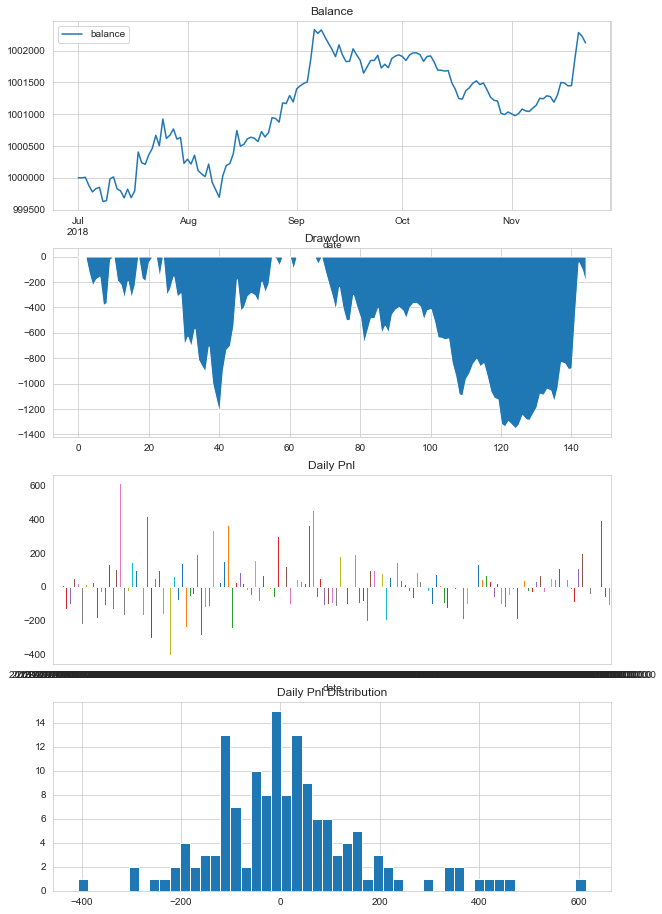

In [163]:
# 显示逐日回测结果
engine.showDailyResult()